In [52]:
# 导入库与全局设置
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TensorMesh
from discretize.utils import ndgrid, mkvc

import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps, data, data_misfit as dm, inverse_problem, regularization as reglib, optimization, directives, inversion


from simpeg.directives import InversionDirective
import tensorflow as tf

from scipy.sparse import csr_matrix, diags
from simpeg.regularization import BaseRegularization
from simpeg import maps
from scipy.sparse import diags, csr_matrix

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
# Geometry and time channel settings (same idea as in 2D-TEM-separate.ipynb)
source_current = 1.0

off_time = 0.0
time_channels = np.logspace(-4, -1, 40)
waveform = tdem.sources.StepOffWaveform(off_time=off_time)

# X-direction receiver locations (can adjust range and step as needed)
receiver_locations = ndgrid(
    np.linspace(-200, 200, 24),
    np.array(0),
    [0]
)

# Transmitter loop (example rectangle)
xyz_loop = np.array([
    [-150, -150, 0], [0, -150, 0], [150, -150, 0], [150, 0, 0],
    [150, 150, 0], [0, 150, 0], [-150, 150, 0], [-150, 0, 0], [-150, -150, 0]
])

# Assemble the source list for the Survey (one LineCurrent source per receiver, measuring dBz/dt)
source_list = []
for i in range(receiver_locations.shape[0]):
    src = tdem.sources.LineCurrent(
        receiver_list=[
            tdem.receivers.PointMagneticFluxTimeDerivative(
                receiver_locations[i:i+1, :], time_channels, "z"
            )
        ],
        location=xyz_loop,
        waveform=waveform,
        current=source_current,
    )
    source_list.append(src)

survey_tem = tdem.Survey(source_list)

n_x = receiver_locations.shape[0]
n_time = time_channels.size


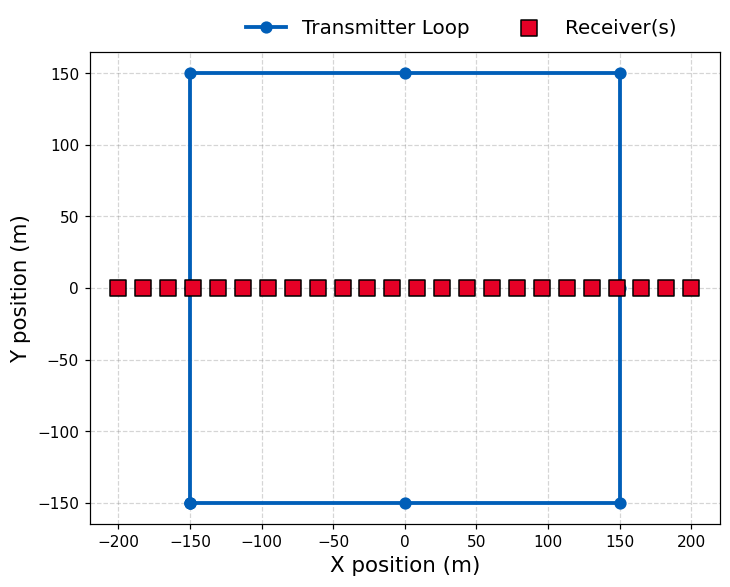

In [ ]:

# Plot the spatial layout of the transmitter loop and receiver locations (aesthetically enhanced)
fig, ax = plt.subplots(figsize=(7, 7), dpi=110)
xyz_loop_forplot = np.vstack([xyz_loop, xyz_loop[0]])  # Close the transmitter loop for plotting

# Plot the transmitter loop
ax.plot(
    xyz_loop_forplot[:, 0], xyz_loop_forplot[:, 1],
    color="#005eb8", marker="o", markersize=7, linewidth=2.5,
    label="Transmitter Loop"
)

# Plot receiver positions
ax.scatter(
    receiver_locations[:, 0], receiver_locations[:, 1],
    c="#e60026", edgecolor="k", s=120, marker="s", label="Receiver(s)", zorder=5
)

ax.set_xlabel("X position (m)", fontsize=14)
ax.set_ylabel("Y position (m)", fontsize=14)
ax.legend(fontsize=13, frameon=False, shadow=True, loc='center left', bbox_to_anchor=(0.22, 1.05), ncol=2)
ax.grid(True, which="both", ls="--", color="#888888", alpha=0.35)

# Improve display quality and layout
ax.set_aspect('equal', 'box')
fig.tight_layout(pad=2.0)
plt.show()



In [ ]:
# One-click Reconstruction: model/grid/map/data/inversion/visualization
# Configuration
res_layer = 32
a, b = 1, 10000

# m0 is a half-space model with resistivity 200 Ohm·m
m0_phys = np.full((n_x, res_layer), 200.0)

alpha_s, alpha_x, alpha_z = 1e-2, 1.0, 1.0
maxIter, maxIterCG, maxIterLS = 20, 10, 10
rel_noise, noise_floor = 0.03, 0


mesh_lci 维度: nCx = 24 , nCz = 32


TensorMesh: 768 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     24        -12.00         12.00      1.00      1.00    1.00
   y     32       -620.54         -0.00      4.54     47.28    1.08

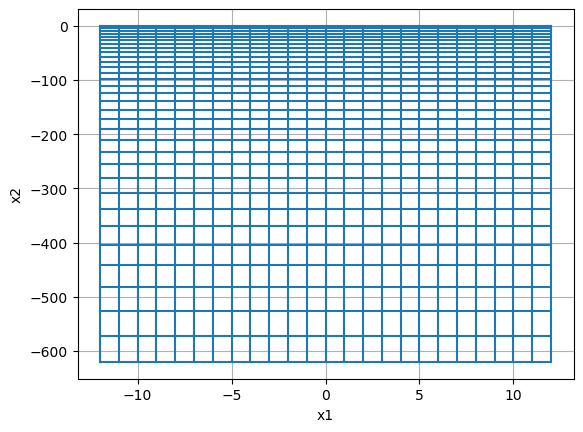

In [ ]:

# 1) Thickness and grid (L layers; half-space is filled in via mapping)
# Generate depth centers with logarithmic spacing using the create_log_depth_grid method
class DummyForGrid:
    def __init__(self, ny):
        self.ny = ny
        self.y_uniform = np.linspace(0, 600, ny + 1)  # Assume a uniform depth from 0 to 600 m, divided into ny layers
    
    def create_log_depth_grid(self, z0=1.0, exponent=2.5):
        y_max = self.y_uniform[-1]
        i = np.linspace(0, 1, self.ny + 1)
        z_edges = z0 * (np.exp(exponent * i) - 1)
        z_edges = z_edges / z_edges[-1] * y_max
        z_centers = (z_edges[:-1] + z_edges[1:]) / 2
        return z_centers

dummy = DummyForGrid(res_layer)
depths = dummy.create_log_depth_grid(z0=1.0, exponent=2.5)

# Calculate thicknesses of each layer
thicknesses = np.r_[np.diff(depths)]

# Define mesh cell sizes
hx = np.ones(n_x)
hz = np.r_[np.diff(depths), np.diff(depths)[-1]]

# Flip hz for correct orientation (from bottom to top)
hz = np.flipud(hz)

# Create 2D tensor mesh (CN means cell-centered)
mesh_lci = TensorMesh([hx, hz], "CN")

# Identity mapping for regularization on the mesh
reg_map_lci = maps.IdentityMap(nP=mesh_lci.nC)

# Plot the mesh grid
mesh_lci.plot_grid()

print("mesh_lci dimensions: nCx =", mesh_lci.shape_cells[0], ", nCz =", mesh_lci.shape_cells[1])
mesh_lci

In [ ]:
# 2) Initial 2D resistivity model (with lateral smoothing) and m0

# 3) Mapping chain and simulation setup
class NewMap(maps.IdentityMap):
    def __init__(self, a=1.0, b=1000.0):
        super().__init__()
        self.a = float(a)
        self.b = float(b)
    def _transform(self, m):
        # Sigmoid type mapping from model space to physical resistivity
        return self.a + (self.b - self.a) / (1.0 + np.exp(-m))
    def deriv(self, m):
        # Derivative of mapping for use in inversion (Jacobian)
        m = np.asarray(m).reshape(-1)
        sig = 1.0 / (1.0 + np.exp(-m))
        drho_dm = (self.b - self.a) * sig * (1.0 - sig)
        from scipy.sparse import diags
        return diags(drho_dm, 0, shape=(m.size, m.size), format="csr")
    

sim_list = []
for i in range(n_x):
    # Create a separate survey and simulation for each column (station)
    survey_i = tdem.Survey([source_list[i]])
    index_i = np.arange(i * res_layer, (i + 1) * res_layer)
    proj_i = maps.Projection(nP=n_x * res_layer, index=index_i)
    rho_map_i = (NewMap(a=a, b=b) * proj_i)
    sim_i = tdem.simulation_1d.Simulation1DLayered(
        survey=survey_i,
        thicknesses=thicknesses,
        rhoMap=rho_map_i,
    )
    sim_list.append(sim_i)

# 4) Data (synthetic)


def logit(x, a=1.0, b=1000.0):
    # Sigmoid inverse for mapping from physical parameters to model space
    x = np.clip(x, a + 1e-8, b - 1e-8)
    return np.log(x - a) - np.log(b - x)


m0_phys = np.full((n_x, res_layer), 200.0)  # Initial resistivity model in physical domain
m0 = logit(m0_phys, a=a, b=b).reshape(-1)   # Transform to model space
#true_rho_2d = np.load("D:\教学\深度学习正则化\拟2DTEM正则化\inversion_model.npy")
true_rho_2d = np.load("D:\教学\深度学习正则化\拟2DTEM正则化\Train\数据集\测试\case_compared/case.npy")  # True resistivity model

print(true_rho_2d.shape)

m_true_concat = logit(true_rho_2d, a=a, b=b).reshape(-1)  # True model in model space


(24, 32)


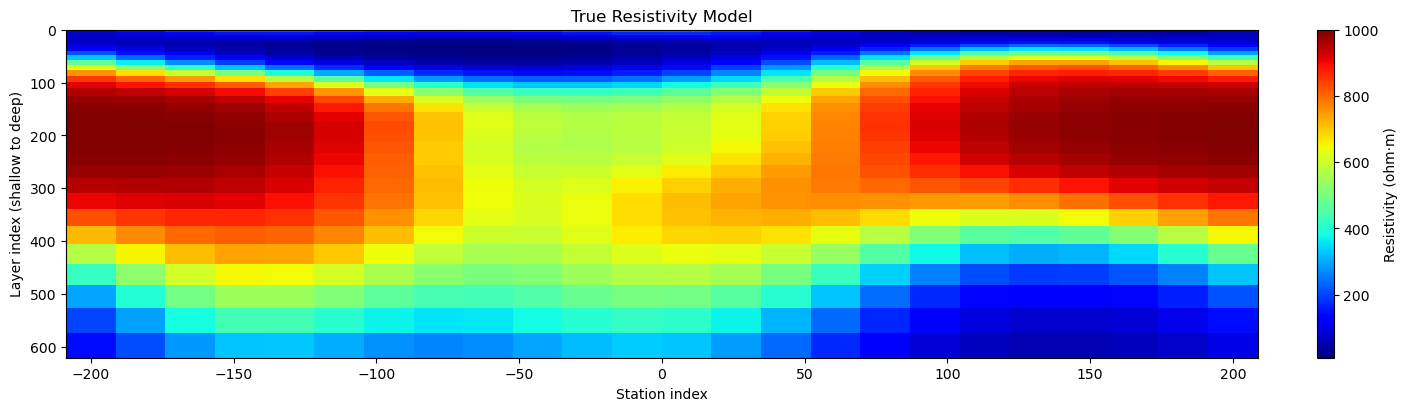

In [ ]:

# True resistivity model
rho_true = true_rho_2d

# Plotting: compare the inversion result with the true resistivity model
fig, axes = plt.subplots(1, 1, figsize=(14, 4), layout="compressed", sharey=True)

# Set the colorbar min/max values to be consistent across plots
vmin = np.min(rho_true)
vmax = np.max(rho_true)

# Generate meshgrid for axis (for pcolormesh or contourf)
X, Y = np.meshgrid(np.arange(n_x), np.arange(res_layer))

# y-coordinates from receiver locations (typically survey stations)
y_coords = receiver_locations[:, 0]

# Calculate the interfaces between layers (from shallow to deep)
layer_interfaces = np.concatenate(([0], np.cumsum(hz[::-1])))  # hz[::-1]: shallow to deep
depth_centers = 0.5 * (layer_interfaces[:-1] + layer_interfaces[1:])

levels = np.linspace(vmin, vmax, 100)

# Use pcolormesh (can also use contourf) to plot the true resistivity model, with colorbar
cf0 = axes.pcolormesh(y_coords, depth_centers, rho_true.T, cmap="jet", vmin=vmin, vmax=vmax)
axes.set_xlabel("Station index")
axes.set_ylabel("Layer index (shallow to deep)")
axes.set_title("True Resistivity Model")

# Invert y-axis so depth increases downward
plt.gca().invert_yaxis()

plt.colorbar(cf0, ax=axes, label="Resistivity (ohm·m)")
plt.show()


In [ ]:
def load_transient_em_data(tem_data, times, percent_noise=0.03):
    '''
        tem_data: original transient EM data
        times: time channels
        percent_noise: relative percent Gaussian noise
    '''
    B0 = tem_data  # Original data

    # Add Gaussian noise
    G = np.random.normal(0, 1, size=B0.shape)
    noise_no_BG = G * B0 * percent_noise
    B_noisy = noise_no_BG

    return B_noisy 

In [60]:

dobs_list, noise_std_list = [], []
for i, sim_i in enumerate(sim_list):
    sl = slice(i*res_layer, (i+1)*res_layer)
    m_local = np.zeros_like(m_true_concat)
    m_local[sl] = m_true_concat[sl]

    dpred_i = sim_i.dpred(m_local)
    sigma_i = np.maximum(np.abs(dpred_i)*rel_noise, noise_floor)
    # sigma_i = abs(load_transient_em_data(abs(dpred_i),time_channels,0.03))
    dobs_i = dpred_i+load_transient_em_data((dpred_i),time_channels,0.03)
    dobs_list.append(dobs_i)
    noise_std_list.append(sigma_i)

dobs = np.concatenate(dobs_list)
noise_std = np.concatenate(noise_std_list)


In [61]:
# np.save('dbt',dobs)

In [ ]:
class GradientRegularization(BaseRegularization):
    """
    Regularization term based on model gradients.
    """

    def __init__(self, nn_model, mesh, beta=1.0, a=1, b=1000, weights=None, **kwargs):
        """
        mesh: SimPEG mesh object, should provide mesh.shape_cells (n_x, n_layers)
        beta: regularization weight factor
        weights: optional, an array controlling spatial weights, default is all ones
        """
        super().__init__(mesh, **kwargs)
        self.mesh = mesh
        self.nn_model = nn_model
        self.a = a
        self.b = b
        self.beta = float(beta)
        n_cells = np.prod(self.mesh.shape_cells)
        if weights is not None:
            self.weights = np.array(weights).reshape(-1)
        else:
            self.weights = np.ones(n_cells)

    def _compute_gradients(self, m):
        """
        Return horizontal (x) and vertical (z) gradients of m, shape: (n_x, n_layers)
        """
        n_x, n_layers = self.mesh.shape_cells
        m = np.reshape(m, (n_x, n_layers))
        # Forward difference
        grad_x = np.zeros_like(m)
        grad_z = np.zeros_like(m)
        grad_x[:-1, :] = m[1:, :] - m[:-1, :]
        grad_z[:, :-1] = m[:, 1:] - m[:, :-1]
        return grad_x, grad_z

    @tf.function
    def _inverse_logit_tf(self, y):
        """
        Inverse logit transformation (TensorFlow).
        """
        return self.a + (self.b - self.a) * tf.exp(y) / (1.0 + tf.exp(y))

    @tf.function
    def _logit_tf(self, x):
        """
        Logit transformation (TensorFlow).
        """
        return tf.math.log(x - self.a) - tf.math.log(self.b - x)

    def mc_dropout_predict(self, noisy_tensor, T=30):
        """
        Perform T forward passes for MC Dropout, return weight array (nC,) for regularization.
        """
        n_x, n_layers = self.mesh.shape_cells
        noisy_tensor = np.reshape(noisy_tensor, (n_x, n_layers))
        m_phys = tf.constant(noisy_tensor, dtype=tf.float32)
        m_phys_input = tf.expand_dims(m_phys, 0)  # (1, n_x, n_layers)
        m_phys_input = tf.expand_dims(m_phys_input, -1)  # (1, n_x, n_layers, 1)
        m_phys_input = self._inverse_logit_tf(m_phys_input)

        preds = []
        for _ in range(T):
            pred = self.nn_model(m_phys_input, training=True).numpy()
            preds.append(self._logit_tf(pred))
        preds = np.stack(preds, axis=0)
        std_pred = np.std(preds, axis=0)  # shape: [1, H, W, 1]

        # Normalize std_pred to [0,1]
        std_min = np.min(std_pred)
        std_max = np.max(std_pred)
        if std_max > std_min:
            std_pred_norm = (std_pred - std_min) / (std_max - std_min)
        else:
            std_pred_norm = np.zeros_like(std_pred)
        std_pred = std_pred_norm
        weights = 1 / (1 + std_pred)    # shape: (1, n_x, n_layers, 1)
        return weights.squeeze().flatten()  # shape: (nC,)

    def f_m(self, m):
        """
        Return vector of gradient residuals, multiplied by spatial weights.
        """
        n_x, n_layers = self.mesh.shape_cells
        grad_x, grad_z = self._compute_gradients(m)
        # Compute weights via MC Dropout predictor based on current m
        weights = self.mc_dropout_predict(m)  # (nC,)
        weights_2d = weights.reshape((n_x, n_layers))

        # Ignore gradients on the last row/column (no forward diff available)
        grad_x_used = grad_x[:-1, :]
        grad_z_used = grad_z[:, :-1]
        weights_x = weights_2d[:-1, :].flatten()
        weights_z = weights_2d[:, :-1].flatten()
        grad_vec = np.concatenate([
            grad_x_used.flatten(),
            grad_z_used.flatten()
        ])
        w = np.concatenate([weights_x, weights_z])
        return grad_vec * w

    def f_m_deriv(self, m):
        """
        Compute the Jacobian of the regularization gradient term, return as scipy.sparse matrix.
        """
        from scipy.sparse import lil_matrix

        n_x, n_layers = self.mesh.shape_cells
        nC = n_x * n_layers
        n_grad_x = (n_x - 1) * n_layers
        n_grad_z = n_x * (n_layers - 1)
        n_rows = n_grad_x + n_grad_z
        J = lil_matrix((n_rows, nC))
        m = np.reshape(m, (n_x, n_layers))

        # Gradients in x-direction
        for i in range(n_x - 1):
            for j in range(n_layers):
                idx_row = i * n_layers + j
                idx1 = i * n_layers + j
                idx2 = (i + 1) * n_layers + j
                w = self.weights[idx1]
                J[idx_row, idx2] = w
                J[idx_row, idx1] = -w

        # Gradients in z-direction
        offset = n_grad_x
        for i in range(n_x):
            for j in range(n_layers - 1):
                idx_row = offset + i * (n_layers - 1) + j
                idx1 = i * n_layers + j
                idx2 = i * n_layers + (j + 1)
                w = self.weights[idx1]
                J[idx_row, idx2] = w
                J[idx_row, idx1] = -w

        return J.tocsr()

    def __call__(self, m):
        """
        Evaluate the regularization value.
        """
        r = self.f_m(m)
        return self.beta * np.dot(r, r)

    def deriv(self, m):
        """
        Compute the gradient of the regularization term.
        """
        r = self.f_m(m)
        J = self.f_m_deriv(m)
        grad = 2 * J.T @ r
        return self.beta * grad

    def deriv2(self, m, v=None):
        """
        Compute the Hessian (or Hessian-vector product if v is given).
        """
        J = self.f_m_deriv(m)
        H = 2 * J.T @ J
        if v is not None:
            return self.beta * H @ v
        return self.beta * H

class GradientRegularization_lci(BaseRegularization):
    """
    Regularization term based on model gradients.
    """

    def __init__(self, nn_model, mesh, beta=1.0, a=1, b=1000, weights=None, **kwargs):
        """
        mesh: SimPEG mesh object, should provide mesh.shape_cells (n_x, n_layers)
        beta: regularization weight factor
        weights: optional, an array controlling spatial weights, default is all ones
        """
        super().__init__(mesh, **kwargs)
        self.mesh = mesh
        self.nn_model = nn_model
        self.a = a
        self.b = b
        self.beta = float(beta)
        n_cells = np.prod(self.mesh.shape_cells)
        if weights is not None:
            self.weights = np.array(weights).reshape(-1)
        else:
            self.weights = np.ones(n_cells)

    def _compute_gradients(self, m):
        """
        Return horizontal (x) and vertical (z) gradients of m, shape: (n_x, n_layers)
        """
        n_x, n_layers = self.mesh.shape_cells
        m = np.reshape(m, (n_x, n_layers))
        # Forward difference
        grad_x = np.zeros_like(m)
        grad_z = np.zeros_like(m)
        grad_x[:-1, :] = m[1:, :] - m[:-1, :]
        grad_z[:, :-1] = m[:, 1:] - m[:, :-1]
        return grad_x, grad_z

    @tf.function
    def _inverse_logit_tf(self, y):
        """
        Inverse logit transformation (TensorFlow).
        """
        return self.a + (self.b - self.a) * tf.exp(y) / (1.0 + tf.exp(y))

    @tf.function
    def _logit_tf(self, x):
        """
        Logit transformation (TensorFlow).
        """
        return tf.math.log(x - self.a) - tf.math.log(self.b - x)

    def mc_dropout_predict(self, noisy_tensor, T=30):
        """
        Perform T forward passes for MC Dropout, return weight array (nC,) for regularization.
        """
        n_x, n_layers = self.mesh.shape_cells
        noisy_tensor = np.reshape(noisy_tensor, (n_x, n_layers))
        m_phys = tf.constant(noisy_tensor, dtype=tf.float32)
        m_phys_input = tf.expand_dims(m_phys, 0)  # (1, n_x, n_layers)
        m_phys_input = tf.expand_dims(m_phys_input, -1)  # (1, n_x, n_layers, 1)
        m_phys_input = self._inverse_logit_tf(m_phys_input)

        preds = []
        for _ in range(T):
            pred = self.nn_model(m_phys_input, training=True).numpy()
            preds.append(self._logit_tf(pred))
        preds = np.stack(preds, axis=0)
        std_pred = np.std(preds, axis=0)  # shape: [1, H, W, 1]

        # Normalize std_pred to [0,1]
        std_min = np.min(std_pred)
        std_max = np.max(std_pred)
        if std_max > std_min:
            std_pred_norm = (std_pred - std_min) / (std_max - std_min)
        else:
            std_pred_norm = np.zeros_like(std_pred)
        std_pred = std_pred_norm
        weights = 1 / (1 + std_pred)    # shape: (1, n_x, n_layers, 1)
        return weights.squeeze().flatten()*0+1  # shape: (nC,)

    def f_m(self, m):
        """
        Return vector of gradient residuals, multiplied by spatial weights.
        """
        n_x, n_layers = self.mesh.shape_cells
        grad_x, grad_z = self._compute_gradients(m)
        # Compute weights via MC Dropout predictor based on current m
        weights = self.mc_dropout_predict(m)  # (nC,)
        weights_2d = weights.reshape((n_x, n_layers))

        # Ignore gradients on the last row/column (no forward diff available)
        grad_x_used = grad_x[:-1, :]
        grad_z_used = grad_z[:, :-1]
        weights_x = weights_2d[:-1, :].flatten()
        weights_z = weights_2d[:, :-1].flatten()
        grad_vec = np.concatenate([
            grad_x_used.flatten(),
            grad_z_used.flatten()
        ])
        w = np.concatenate([weights_x, weights_z])
        return grad_vec * w

    def f_m_deriv(self, m):
        """
        Compute the Jacobian of the regularization gradient term, return as scipy.sparse matrix.
        """
        from scipy.sparse import lil_matrix

        n_x, n_layers = self.mesh.shape_cells
        nC = n_x * n_layers
        n_grad_x = (n_x - 1) * n_layers
        n_grad_z = n_x * (n_layers - 1)
        n_rows = n_grad_x + n_grad_z
        J = lil_matrix((n_rows, nC))
        m = np.reshape(m, (n_x, n_layers))

        # Gradients in x-direction
        for i in range(n_x - 1):
            for j in range(n_layers):
                idx_row = i * n_layers + j
                idx1 = i * n_layers + j
                idx2 = (i + 1) * n_layers + j
                w = self.weights[idx1]
                J[idx_row, idx2] = w
                J[idx_row, idx1] = -w

        # Gradients in z-direction
        offset = n_grad_x
        for i in range(n_x):
            for j in range(n_layers - 1):
                idx_row = offset + i * (n_layers - 1) + j
                idx1 = i * n_layers + j
                idx2 = i * n_layers + (j + 1)
                w = self.weights[idx1]
                J[idx_row, idx2] = w
                J[idx_row, idx1] = -w

        return J.tocsr()

    def __call__(self, m):
        """
        Evaluate the regularization value.
        """
        r = self.f_m(m)
        return self.beta * np.dot(r, r)

    def deriv(self, m):
        """
        Compute the gradient of the regularization term.
        """
        r = self.f_m(m)
        J = self.f_m_deriv(m)
        grad = 2 * J.T @ r
        return self.beta * grad

    def deriv2(self, m, v=None):
        """
        Compute the Hessian (or Hessian-vector product if v is given).
        """
        J = self.f_m_deriv(m)
        H = 2 * J.T @ J
        if v is not None:
            return self.beta * H @ v
        return self.beta * H



In [ ]:


import os
os.chdir('..')
loaded_model = tf.keras.models.load_model('./model_train/reg_model.h5',)
mask_model = tf.keras.models.load_model('./model_train/imaging_model.h5')




In [ ]:
class BetaExpDecayAndSmoothNet(directives.InversionDirective):
    """
    After each iteration, update the regularization parameter beta by exponential decay, 
    then use a neural network to try smoothing the model (in physical space) and 
    check if the objective function is improved. If improved, substitute the new model.
    """
    def __init__(self, nn_model, a, b, mesh, mis=None, beta0=10.0, dobs=dobs, beta_min=0.01, n_iter_target=10, T=30, noise=0.05):
        super().__init__()
        self.nn_model = nn_model
        self.a = a
        self.b = b
        self.mesh = mesh
        self.beta0 = float(beta0)
        self.beta_min = float(beta_min)
        self.n_iter_target = int(n_iter_target)
        self.T = T
        self.decay_factor = (self.beta_min / self.beta0) ** (1 / float(self.n_iter_target))
        self.dobs = dobs

        if mis is None:
            self.mis = np.ones_like(self.dobs)
        else:
            self.mis = mis

        self.noise = noise

    def _inverse_logit(self, y):
        # Convert from logit to physical parameter space
        return self.a + (self.b - self.a) * (np.exp(y) / (1.0 + np.exp(y)))

    def _logit(self, x):
        # Convert from physical parameter space to logit
        eps = 1e-1
        new_x = np.clip(x, self.a + eps, self.b - eps)
        return np.log(new_x - self.a) - np.log(self.b - new_x)

    def initialize(self):
        # Initialize beta and history storage
        self.reg.beta = self.beta0
        self.model_smoothed = []
        self.model = []

    def endIter(self):
        # 1. Try neural network smoothing; if objective improves, update the model

        model_inv = np.array(self.opt.xc)
        n_x, n_layers = self.mesh.shape_cells
        model_inv_reshaped = model_inv.reshape((n_x, n_layers))
        model_phys = self._inverse_logit(model_inv_reshaped)[np.newaxis, :, :, np.newaxis]

        preds = []
        for _ in range(self.T):
            pred = self.nn_model(model_phys, training=True)
            preds.append(self._logit(pred))
        preds = np.stack(preds, axis=0)
        mean_pred = np.mean(preds, axis=0)   # [1, H, W, 1]
        smoothed = mean_pred.flatten()
        smoothed = 0.7 * smoothed + 0.3 * model_inv  # Weighted blend between smoothed and original

        f = self.invProb.getFields(smoothed, store=False)
        noise_std = self.noise * np.abs(self.dobs)

        # Data misfit (RMS) calculation
        dpred_smooth = self.invProb.get_dpred(smoothed, f)
        dpred_orig = self.invProb.dpred

        phi_d_smooth = np.sqrt(np.mean(self.mis * ((dpred_smooth - self.dobs) / noise_std) ** 2))
        phi_d_orig = np.sqrt(np.mean(self.mis * ((dpred_orig - self.dobs) / noise_std) ** 2))

        # Regularization term
        phi_m_orig = self.invProb.reg.objfcts[1](model_inv)
        phi_m_smooth = self.invProb.reg.objfcts[1](smoothed)

        # If the smoothed model has better or comparable data fit, adopt it

        if phi_d_smooth <= phi_d_orig or np.abs(phi_d_smooth-phi_d_orig)/phi_d_orig<0.1:
                print(f"Applied NN-smoothing: phi_d_smoothed={phi_d_smooth:.3e}, phi_d={phi_d_orig:.3e}, phi_m_smoothed={phi_m_smooth:.3e}, phi_m={phi_m_orig:.3e}")
                self.opt.xc = smoothed
                self.model_smoothed.append(smoothed)
                self.model.append(model_inv)

        self.invProb.reg.reference_model = smoothed


        # 2. update beta
        iteration = self.opt.iter
        new_beta = self.beta0 * (self.decay_factor ** iteration)
        new_beta = max(new_beta, self.beta_min)
        self.invProb.beta = new_beta


In [ ]:
# 5) inversion
from simpeg import data_misfit as dm

dmis_LCI = None
for i, sim_i in enumerate(sim_list):
    # Get the survey associated with the current simulation
    survey_i = sim_i.survey
    # Get the slice for the current time indices
    sl = slice(i * n_time, (i + 1) * n_time)
    # Create a data object for the current survey and observed data
    data_i = data.Data(survey=survey_i, dobs=dobs[sl], standard_deviation=noise_std[sl])
    # Construct the L2 data misfit object for the current simulation
    dmis_i = dm.L2DataMisfit(data=data_i, simulation=sim_i)
    # Sum the misfits for all simulations
    dmis_LCI = dmis_i if dmis_LCI is None else (dmis_LCI + dmis_i)


# LCI and DL-Regularization inversion

In [ ]:

class SavePhi(directives.InversionDirective):
    def initialize(self):
        self.rms_lci = []

    def endIter(self):
        noise_std = 0.05 * np.abs(dobs)
        rms_lci = np.sqrt(np.mean(((self.invProb.dpred - dobs) / noise_std) ** 2))
        self.rms_lci.append(rms_lci)

        print(f" RMS={rms_lci:.3e}")

grad_dl = GradientRegularization(
    nn_model=loaded_model,
    mesh = mesh_lci,    
    beta=10,
    a=a,
    b=b
)

grad_lci = GradientRegularization_lci(
    nn_model=loaded_model,
    mesh = mesh_lci,    
    beta=10,
    a=a,
    b=b
)

reg_lci = reglib.WeightedLeastSquares(
    mesh_lci,
    alpha_s=0.01,
    mapping=reg_map_lci,
)

# DL-Regularization inversion
reg =  reg_lci + grad_dl
# #DL-Regularization inversion
# reg =  reg_lci + grad_lci

opt_lci = optimization.ProjectedGNCG(maxIter=10, maxIterCG=10, maxIterLS=10)

inv_prob_lci = inverse_problem.BaseInvProblem(dmis_LCI, reg, opt_lci)

SavePhi = SavePhi()
target_misfit_lci = directives.TargetMisfit(chifact=1)

# 创建自适应 beta 指令
BetaExpDecayAndSmoothNet = BetaExpDecayAndSmoothNet(
nn_model=loaded_model, a=a, b=b, mesh=mesh_lci, 
beta0=1.0, beta_min=0.01, n_iter_target=20,T=30,dobs = dobs,noise = 0.05)


inv_lci = inversion.BaseInversion(
    inv_prob_lci,
    [ target_misfit_lci,SavePhi,BetaExpDecayAndSmoothNet],
)

mrec_lci = inv_lci.run(m0)



Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  5.20e+05  0.00e+00  5.20e+05    1.69e+05      0              
 RMS=9.186e+00
Applied NN-smoothing: phi_d_smoothed=9.043e+00, phi_d=9.186e+00, phi_m_smoothed=9.402e+01, phi_m=1.014e+02
   1  7.94e-01  2.18e+05  2.84e+02  2.18e+05    9.91e+04      1              
 RMS=6.001e+00
Applied NN-smoothing: phi_d_smoothed=5.

# independent inversion

In [ ]:
'''
class SavePhi(directives.InversionDirective):
    def initialize(self):
        self.rms_lci = []

    def endIter(self):

        rms_lci = np.sqrt(np.mean(((self.invProb.dpred - dobs) / noise_std) ** 2))
        self.rms_lci.append(rms_lci)

        model_current = np.array(self.opt.xc)
        model_true = np.array(m_true_concat)
        # self.invProb.model
        phi_d = self.invProb.dmisfit(model_current)
        phi_m = self.invProb.reg(model_current)   # 👈 这就是正则化项
        # print(f"Iter {self.opt.iter}: phi_d={phi_d:.3e}, phi_m={phi_m:.3e}")
        print(f" RMS={rms_lci:.3e}")
        # print(f" Model={np.mean((model_current-model_true)**2):.3e}")



reg_lci = reglib.WeightedLeastSquares(
    mesh_lci,
    alpha_s=0.01,
    mapping=reg_map_lci,

)
## single
reg =  reg_lci

opt_lci = optimization.ProjectedGNCG(maxIter=20, maxIterCG=maxIterCG, maxIterLS=maxIterLS)

inv_prob_lci = inverse_problem.BaseInvProblem(dmis_LCI, reg, opt_lci)

SavePhi = SavePhi()
target_misfit_lci = directives.TargetMisfit(chifact=1)

# 创建自适应 beta 指令
BetaExpDecayAndSmoothNet = BetaExpDecayAndSmoothNet(
nn_model=loaded_model, a=a, b=b, mesh=mesh_lci, 
beta0=1.0, beta_min=0.01, n_iter_target=maxIter,T=30)


inv_lci = inversion.BaseInversion(
    inv_prob_lci,
    [ target_misfit_lci,SavePhi,BetaExpDecayAndSmoothNet],
)

mrec_lci = inv_lci.run(m0)
'''

'# 5) dmis_LCI\nfrom simpeg import data_misfit as dm\n\nclass SavePhi(directives.InversionDirective):\n    def initialize(self):\n        self.rms_lci = []\n\n    def endIter(self):\n\n        rms_lci = np.sqrt(np.mean(((self.invProb.dpred - dobs) / noise_std) ** 2))\n        self.rms_lci.append(rms_lci)\n\n        model_current = np.array(self.opt.xc)\n        model_true = np.array(m_true_concat)\n        # self.invProb.model\n        phi_d = self.invProb.dmisfit(model_current)\n        phi_m = self.invProb.reg(model_current)   # 👈 这就是正则化项\n        # print(f"Iter {self.opt.iter}: phi_d={phi_d:.3e}, phi_m={phi_m:.3e}")\n        print(f" RMS={rms_lci:.3e}")\n        # print(f" Model={np.mean((model_current-model_true)**2):.3e}")\n\n\n\nreg_lci = reglib.WeightedLeastSquares(\n    mesh_lci,\n    alpha_s=0.01,\n    mapping=reg_map_lci,\n\n)\n## single\nreg =  reg_lci\n\nopt_lci = optimization.ProjectedGNCG(maxIter=20, maxIterCG=maxIterCG, maxIterLS=maxIterLS)\n\ninv_prob_lci = inverse_prob

In [ ]:

# Recover the inverted resistivity model
rho_lci = np.zeros((n_x, res_layer))
for i in range(n_x):
    sl = slice(i * res_layer, (i + 1) * res_layer)
    rho_lci[i, :] = NewMap(a=a, b=b)._transform(mrec_lci[sl])
    # rho_lci[i, :] = np.exp(mrec_lci[sl])  # (alt, not used)
rho_lci = loaded_model((rho_lci)[np.newaxis, ..., np.newaxis]).numpy().squeeze()

# True resistivity model
rho_true = np.zeros_like(rho_lci)
for i in range(n_x):
    sl = slice(i * res_layer, (i + 1) * res_layer)
    rho_true[i, :] = NewMap(a=a, b=b)._transform(m_true_concat[sl])
    # rho_true[i, :] = np.exp(m_true_concat[sl])  # (alt, not used)


In [75]:
rho_lci_expanded = (rho_lci)[np.newaxis, ..., np.newaxis]
rho_lci_tf = mask_model(rho_lci_expanded)
rho_lci_tf = rho_lci_tf.numpy().squeeze()




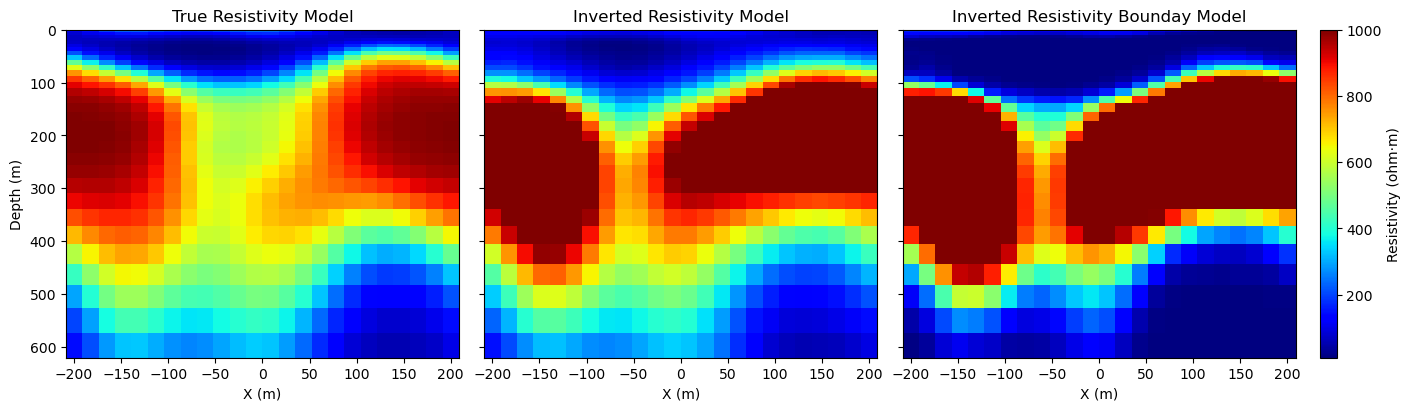

In [ ]:
# Plotting: Compare inverted and true resistivity models
fig, axes = plt.subplots(1, 3, figsize=(14, 4), layout="compressed", sharey=True)

# Set the same colorbar value range using vmin/vmax
vmin = np.min(rho_true)
vmax = np.max(rho_true)

# Use a filled contour plot (contourf) instead of imshow; add colorbar
X, Y = np.meshgrid(np.arange(n_x), np.arange(res_layer))

y_coords = receiver_locations[:,0]

# Calculate layer interfaces (from shallow to deep)
layer_interfaces = np.concatenate(([0], np.cumsum(hz[::-1])))
# Calculate the center of each depth layer
depth_centers = 0.5 * (layer_interfaces[:-1] + layer_interfaces[1:])

levels = np.linspace(vmin, vmax, 100)

cf0 = axes[0].pcolormesh(y_coords, depth_centers, rho_true.T,  cmap="jet", vmin=vmin, vmax=vmax)
axes[0].set_xlabel("X (m)")
axes[0].set_ylabel("Depth (m)")
axes[0].set_title("True Resistivity Model")

im1 = axes[1].pcolormesh(y_coords, depth_centers, rho_lci.T,  cmap="jet", vmin=vmin, vmax=vmax)
axes[1].set_xlabel("X (m)")
axes[1].set_title("Inverted Resistivity Model")

im2 = axes[2].pcolormesh(y_coords, depth_centers, rho_lci_tf.T,  cmap="jet", vmin=vmin, vmax=vmax)
axes[2].set_xlabel("X (m)")
axes[2].set_title("Inverted Resistivity Boundary Model")

plt.gca().invert_yaxis()  # Depth increases downward

plt.colorbar(im2, ax=axes[2], label="Resistivity (ohm·m)")
plt.show()

In [ ]:
'''np.save('RMS11.npy',SavePhi.rms_lci)
np.save('model11.npy',rho_lci)

# 保存  11:1  2  3
np.save('BetaExpDecayAndSmoothNet_model11.npy', BetaExpDecayAndSmoothNet.model)
np.save('BetaExpDecayAndSmoothNet_model_smoothed11.npy', BetaExpDecayAndSmoothNet.model_smoothed)'''

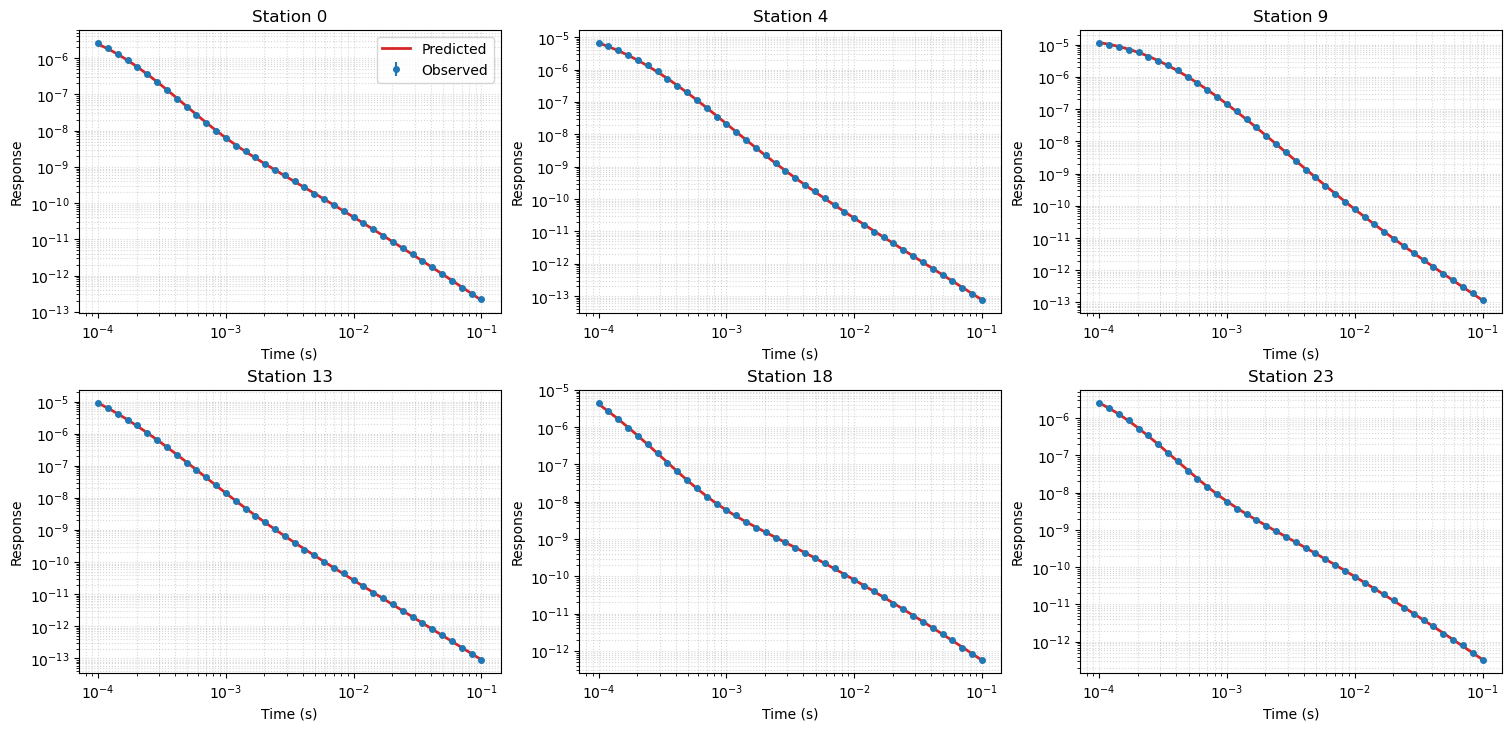

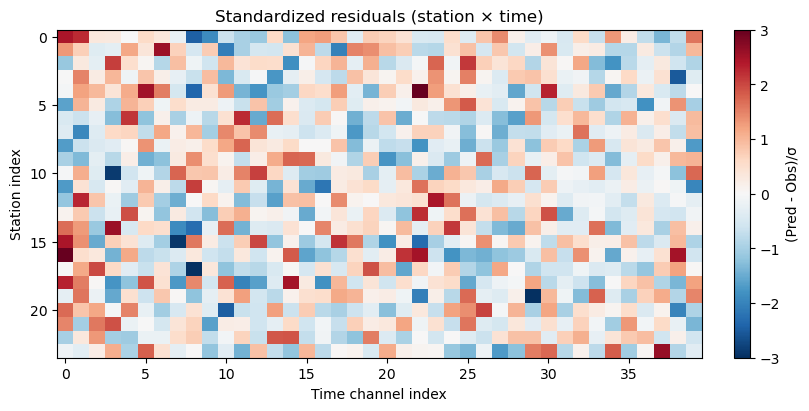

In [ ]:
# Multi-station, multi-time channel observed vs predicted responses (optional error bars)
# Configurable: select the indices of stations to plot
plot_all = False  # If True, plot all stations (might be slow)
num_show = 6      # If plot_all=False, number of stations to plot (selected evenly)
use_errorbar = True

if plot_all:
    station_indices = list(range(n_x))
else:
    if num_show >= n_x:
        station_indices = list(range(n_x))
    else:
        station_indices = np.unique(np.linspace(0, n_x - 1, num_show, dtype=int)).tolist()

# Extract predicted responses for each station
dpred_list = []
for i, sim_i in enumerate(sim_list):
    dpred_list.append(sim_i.dpred(mrec_lci))
dpred = np.stack(dpred_list, axis=0)  # shape: (n_x, n_time)

# Observed data and noise
dobs_mat = np.zeros((n_x, n_time))
noise_mat = np.zeros((n_x, n_time))
for i in range(n_x):
    sl = slice(i * n_time, (i + 1) * n_time)
    dobs_mat[i, :] = dobs[sl]
    noise_mat[i, :] = noise_std[sl]

# Plot: one subplot per station
n_cols = 3
n_rows = int(np.ceil(len(station_indices) / n_cols)) if len(station_indices) > 0 else 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.6 * n_rows), layout="compressed")
axes = np.atleast_1d(axes).ravel()

for ax_idx, (ax, i) in enumerate(zip(axes, station_indices)):
    y_obs = abs(dobs_mat[i])
    y_pre = abs(dpred[i])
    y_err = noise_mat[i]

    # Semi-log x axis
    if use_errorbar:
        ax.errorbar(time_channels, y_obs, yerr=y_err, fmt="o", ms=4, color="#1f77b4", label="Observed")
    else:
        ax.loglog(time_channels, y_obs, "o", ms=4, color="#1f77b4", label="Observed")
    ax.loglog(time_channels, y_pre, "-", lw=2, color="#d62728", label="Predicted")

    ax.set_xscale("log")
    ax.grid(True, which="both", ls=":", alpha=0.5)
    ax.set_title(f"Station {i}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Response")
    if ax_idx == 0:
        ax.legend()

# Remove unused empty subplots
for k in range(len(station_indices), len(axes)):
    fig.delaxes(axes[k])

plt.show()
